# Center Loss with Transfer Learning (InceptionV3) Evaluation

Fine Tune version with 50 epochs training

In [1]:
%matplotlib notebook

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [2]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
from utils import create_testdata, tbProjector, PCAPlotter

## Check the Number of Test Data

In [5]:
image_dir = "image_data"
emb_size = 128

In [6]:
test_dir = os.path.join(image_dir, "test")
print(test_dir)
print("items = {}".format(len(os.listdir(test_dir))))

image_data/test
items = 89


In [7]:
all_images_test = 0
class_list_test = sorted(os.listdir(test_dir))
for i in class_list_test:
    #print(i)
    all_images_test += len(os.listdir(os.path.join(test_dir, i)))
print("All test image files = {}".format(all_images_test))
#print("class_list[:10] = {}".format(class_list[:10]))

All test image files = 1447


## Specify model file

In [8]:
#epoch_time = '1600847846' # Change this depending on the model I want to evaluate

#model_file = 'siameseN_inceptionV3_{}.h5'.format(epoch_time)
#emb_file = 'embeddings_inceptionV3_{}.h5'.format(epoch_time)
#tblog_dir = 'logs_eval/logs-{}'.format(epoch_time)

reduced_file = "reduced_1605885003.h5"

## See deep-feature plot

In [9]:
from tensorflow.keras.models import load_model

reduced_model = load_model(reduced_file)
reduced_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
side_out (PReLU)             (None, 128)               128 

In [10]:
log_dir = "logs_test/latest"
_TB_METADATA = "metadata.tsv"

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
x_test, x_test_label_list = create_testdata(datadir='test', tblog_dir=log_dir, metadatafile=_TB_METADATA, seed=47)

x_test_labels = list(set(x_test_label_list))

In [11]:
#x_test_label_d = {}
#for i, label in enumerate(list(set(x_test_label_list))):
#    x_test_label_d[label] = i

#print(x_test_label_d)

## Class - Color mapping in plot

In [12]:
from matplotlib import colors as mcolors

#colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']


In [13]:
from sklearn.decomposition import PCA

def visualize_test(feat, y, labels):
    fig = plt.figure(figsize=(5, 5))
    for i in range(len(labels)):
        plt.plot(feat[y == labels[i], 0], feat[y == labels[i], 1], '.', c=c[i])
    plt.show()

def PCA_test(x, y, labels):
    feat = reduced_model.predict(x)
    pca = PCA(n_components=2)
    pca.fit(feat)
    pca_feat = pca.transform(feat)
    visualize_test(pca_feat, np.array(y), np.array(labels))
    
    

<IPython.core.display.Javascript object>


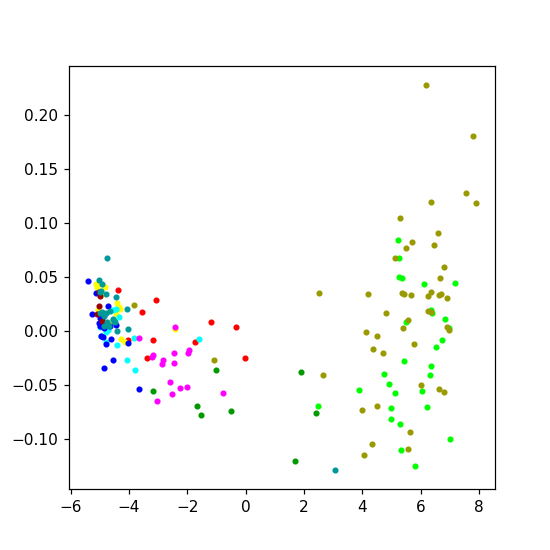

In [14]:
PCA_test(x_test, x_test_label_list, x_test_labels)

<IPython.core.display.Javascript object>


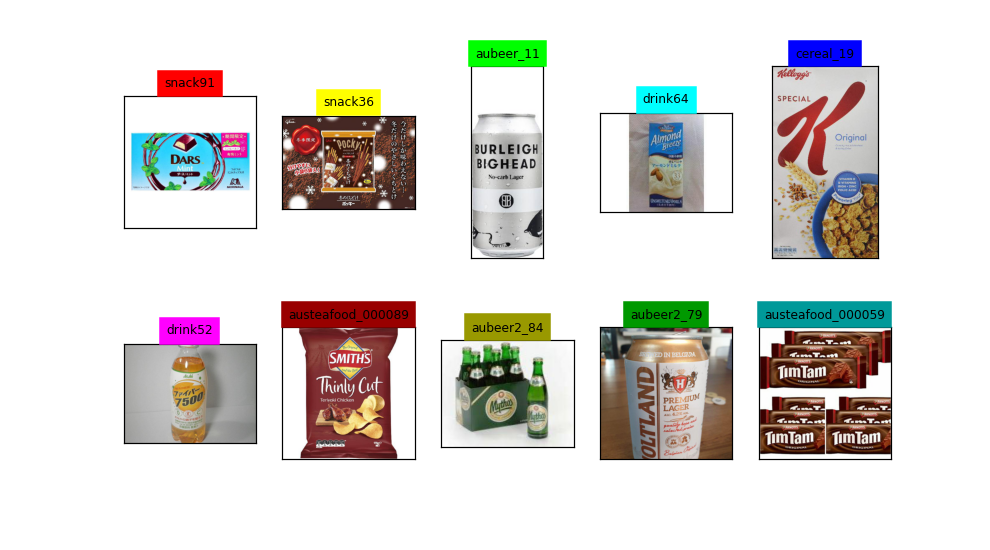

In [15]:
_row = 2
_col = 5
axs = plt.figure(figsize=(9, 5)).subplots(2, 5)

for i, label in enumerate(x_test_labels):
    label_dir = os.path.join(test_dir, label)
    item_list = os.listdir(label_dir)
    img = tf.keras.preprocessing.image.load_img(os.path.join(label_dir, item_list[0]))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    axs[i//_col, i%_col].imshow(img)
    axs[i//_col, i%_col].set_title(label, backgroundcolor=c[i], fontdict={'fontsize': 8})
    axs[i//_col, i%_col].set_xticks([])
    axs[i//_col, i%_col].set_yticks([])

plt.xticks([])
plt.yticks([])
plt.show()

## Evaluation

Use **CMC** (Cumulative Match Characteristics)

https://stats.stackexchange.com/questions/142323/cumulative-match-score

Make a list of deep-features of images from each class in test directory. Only one image is selected per class, and it was chosen as it seemed to most represent the class(item).

Then I will randomly choose some images from test directory and predict the item by searching the image embeddings list. The item in the list which has the least distance to the target image is supposed to most likely be the class the target image belongs to. 

### 1. make the list of representative embeddings(deep features)

In [16]:
# Make the feature list of representative images

rep_file = 'representatives.txt'

if not os.path.exists(rep_file):

    rep_list = []
    testdir_list = os.listdir(test_dir)

    for i, td in enumerate(testdir_list):
        td_path = os.path.join(test_dir, td)
        # Get the first image in the directory as an embedding
        img_file = os.path.join(td_path, sorted(os.listdir(td_path))[0])
        rep_list.append(img_file)

    with open(rep_file, 'w') as wf:
        for line in rep_list:
            wf.write("{}\n".format(line))

In [17]:
with open(rep_file, 'r') as rf:
    rep_emb_list = rf.readlines()

In [18]:
rep_emb_list = [ el.strip('\n') for el in rep_emb_list]
#print(emb_list)

<IPython.core.display.Javascript object>


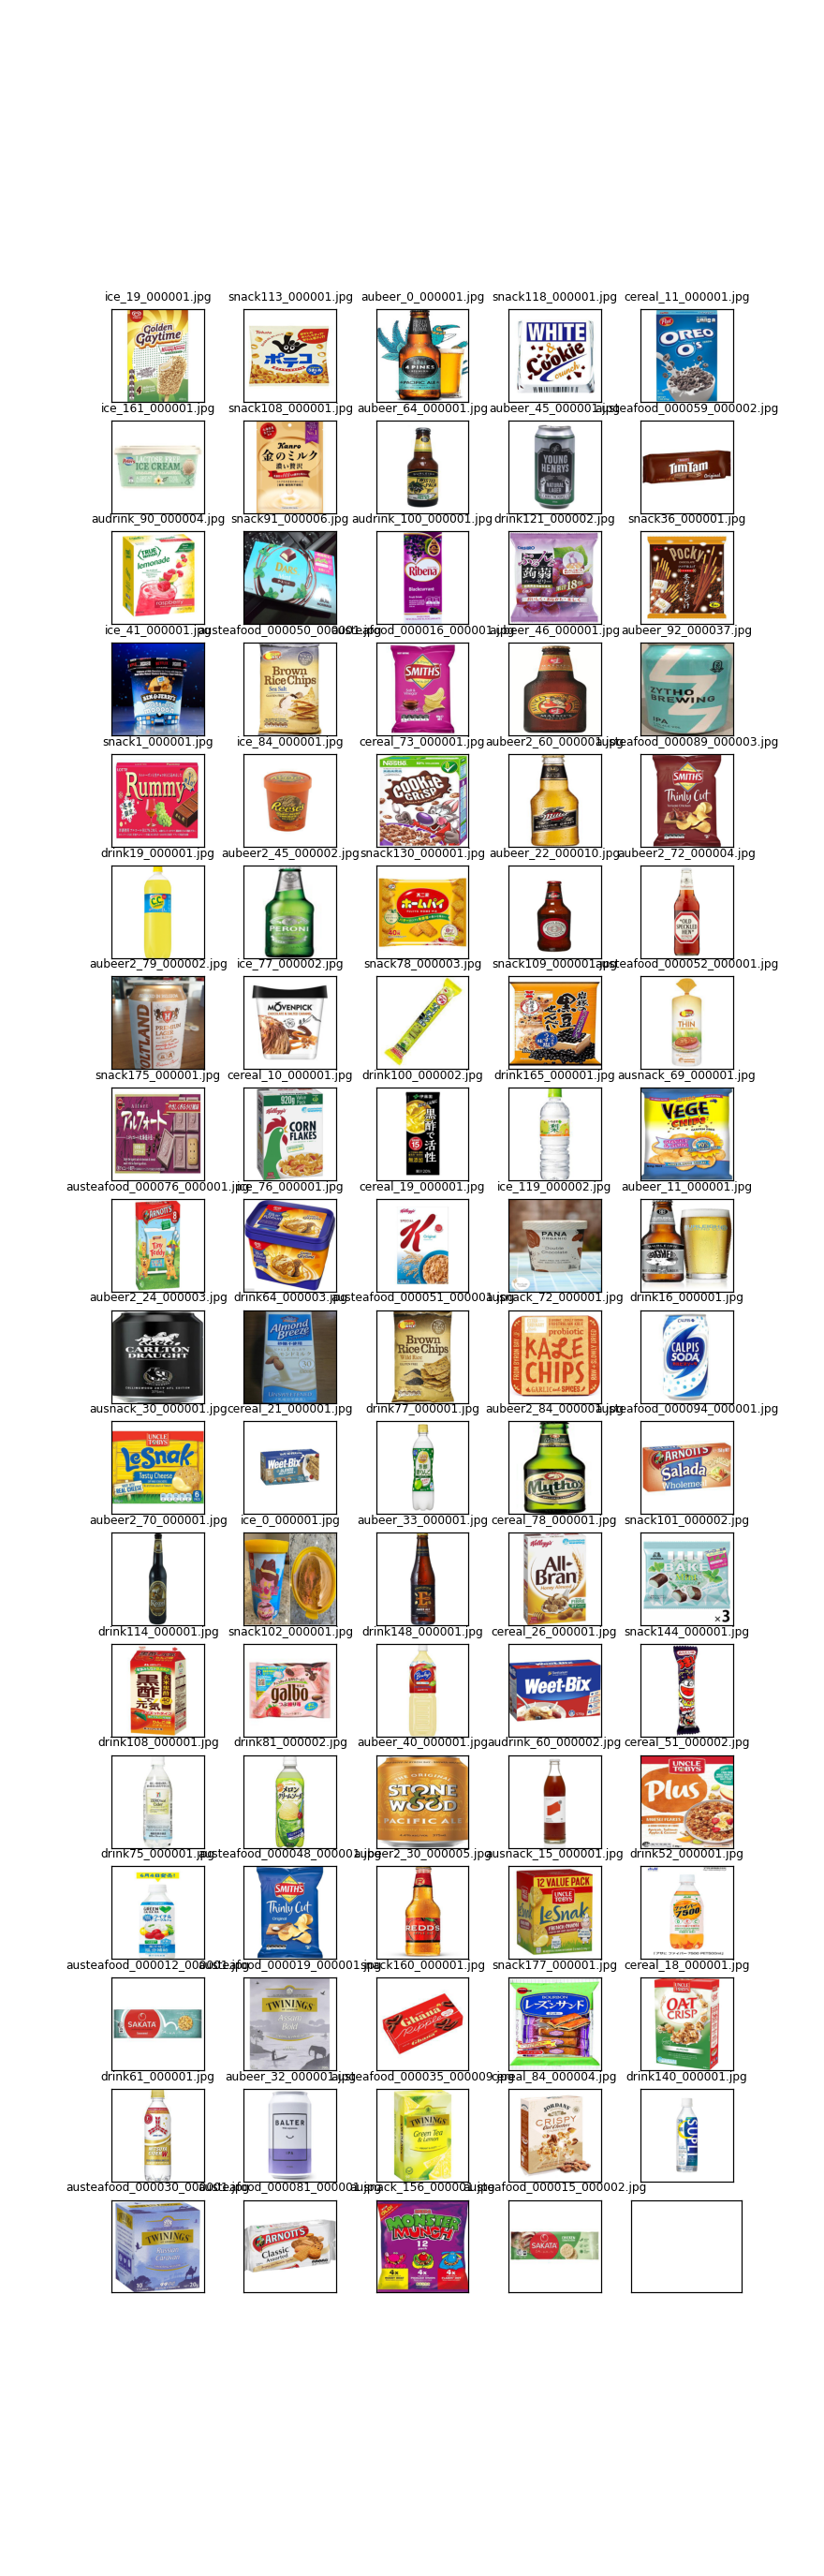

In [19]:
testdir_list = os.listdir(test_dir)

_row = ((len(testdir_list) - 1) // 5) + 1 
_col = 5
fig2, axs2 = plt.subplots(_row, 5, figsize=(8,25))

for i, el in enumerate(rep_emb_list):
    
    img = tf.keras.preprocessing.image.load_img(el)
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    
    #img_input = np.expand_dims(img, axis=0) 
    #test_embeddings_list[i] = emb_model.predict(img_input)
    
    axs2[i//_col, i%_col].imshow(img)
    axs2[i//_col, i%_col].set_title(el.split('/')[-1], fontsize=8)
    axs2[i//_col, i%_col].set_xticks([])
    axs2[i//_col, i%_col].set_yticks([])
    
plt.xticks([])
plt.yticks([])
plt.show()

In [20]:
#plt.close(fig2)

In [21]:
#rep_embeddings = np.zeros((len(testdir_list), emb_size))
#testdir_list = os.listdir(test_dir)

rep_emb_img = []

for i, img_file in enumerate(rep_emb_list):
    
    img = tf.keras.preprocessing.image.load_img(img_file)
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    
    #img_input = np.expand_dims(img, axis=0)
    rep_emb_img.append(img)
    

rep_embeddings = reduced_model.predict(np.array(rep_emb_img))    

### 2. Pick a target image from each class (except for the representative image)

In [22]:
#emb_class_name = [ ec.split('/')[-2] for ec in emb_list ]
#emb_file_name = [ ec.split('/')[-1] for ec in emb_list ]

#test_size = 10
rng = default_rng()
#rand_class = rng.choice(class_list_test, test_size, replace=False)

target_list = [] # target image arrays which are selected randomly from each class
#returned_list = [] # target image embeddings

for i, cls in enumerate(testdir_list):
    
    # Do not choose the identical image as the one in embeddings_list
    #idx = emb_class_name.index(cls)
    #emb_img = emb_file_name[idx]
    
    target_dir = os.path.join(test_dir, cls)
    imglist = os.listdir(target_dir)
    
    rand_img = rng.choice(imglist[1:])
    #rand_img = rand_img[rand_img != emb_img]
        
    target_img_file = os.path.join(target_dir, rand_img)
    
    img = tf.keras.preprocessing.image.load_img(target_img_file)
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    
    #returned_classes = matching(img, count=5)
    
    target_list.append(img)
    #eturned_list.append(returned_classes)

In [23]:
reduced_target = reduced_model.predict(np.array(target_list))

In [24]:
reduced_target.shape

(89, 128)

### 3. Get the euclidean distance for every target samples to representative embeddings of every class

rep_emb_3d = np.expand_dims(rep_embeddings, axis=0) # shape = (1, class_num, emb_dims)
print(rep_emb_3d.shape)

reduced_tar_3d = np.expand_dims(reduced_target, axis=1) # shape = (class_num, 1, emb_dims)
print(reduced_tar_3d.shape)

eu_dist = np.sum((reduced_tar_3d - rep_emb_3d)**2, axis=2) # shape = (class_num, class_num)
print(eu_dist.shape)
#print(eu_dist)

In [25]:
eu_dist = np.zeros((89, 89))
for m in np.arange(reduced_target.shape[0]):
    tar_m = np.array([reduced_target[m],]*reduced_target.shape[0])
    dist = np.sqrt(np.sum((tar_m - rep_embeddings)**2, axis=1))
    eu_dist[m] = dist
    

<IPython.core.display.Javascript object>


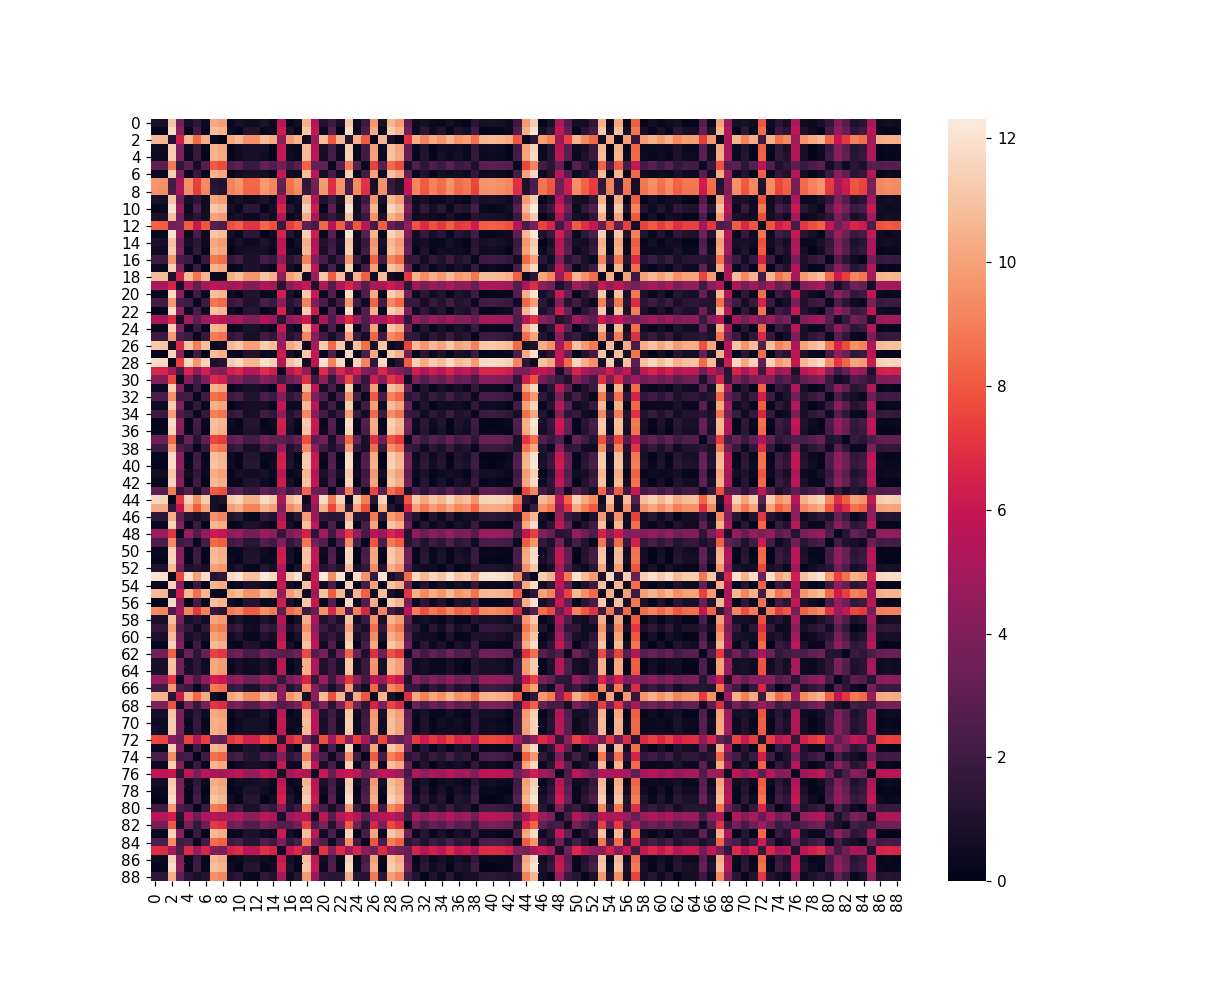

<AxesSubplot:>

In [26]:
import seaborn as sns

fig3, ax3 = plt.subplots(figsize=(11,9))

sns.heatmap(eu_dist)

In [27]:
def get_topK(matrix, k=1):
    '''
    matrix: A matrix(class_num * class_num) which stores distances from 
            target embeddings (row) to every representative embeddings (column)
    k:      Top-K rank (how many points from the top are taken)
    
    return: The number of representatives that are in top-K
    '''
    
    idx = np.arange(matrix.shape[0]).reshape(matrix.shape[0], 1)
    
    # i_th row (target) is the same class as i_th column (representative)
    # So, if i_th column is in top K in i_th row,
    #  it means the representative data that belongs to the class same as the target data is in Top K
    
    asort_matrix = np.argsort(matrix, axis=1)
    asort_k = asort_matrix[:, :k]
    print(asort_k.shape)
    asort_bool = (asort_k - idx) == 0 # True if index of row == index of column
    
    return np.sum(asort_bool), asort_k

In [28]:
for i in range(10):
    detected_num, asort_k = get_topK(eu_dist, k=i+1)
    print("K = {}, detected = {}/{}".format(i+1, detected_num, eu_dist.shape[0]))

(89, 1)
K = 1, detected = 11/89
(89, 2)
K = 2, detected = 16/89
(89, 3)
K = 3, detected = 21/89
(89, 4)
K = 4, detected = 24/89
(89, 5)
K = 5, detected = 28/89
(89, 6)
K = 6, detected = 33/89
(89, 7)
K = 7, detected = 36/89
(89, 8)
K = 8, detected = 39/89
(89, 9)
K = 9, detected = 40/89
(89, 10)
K = 10, detected = 43/89


<IPython.core.display.Javascript object>


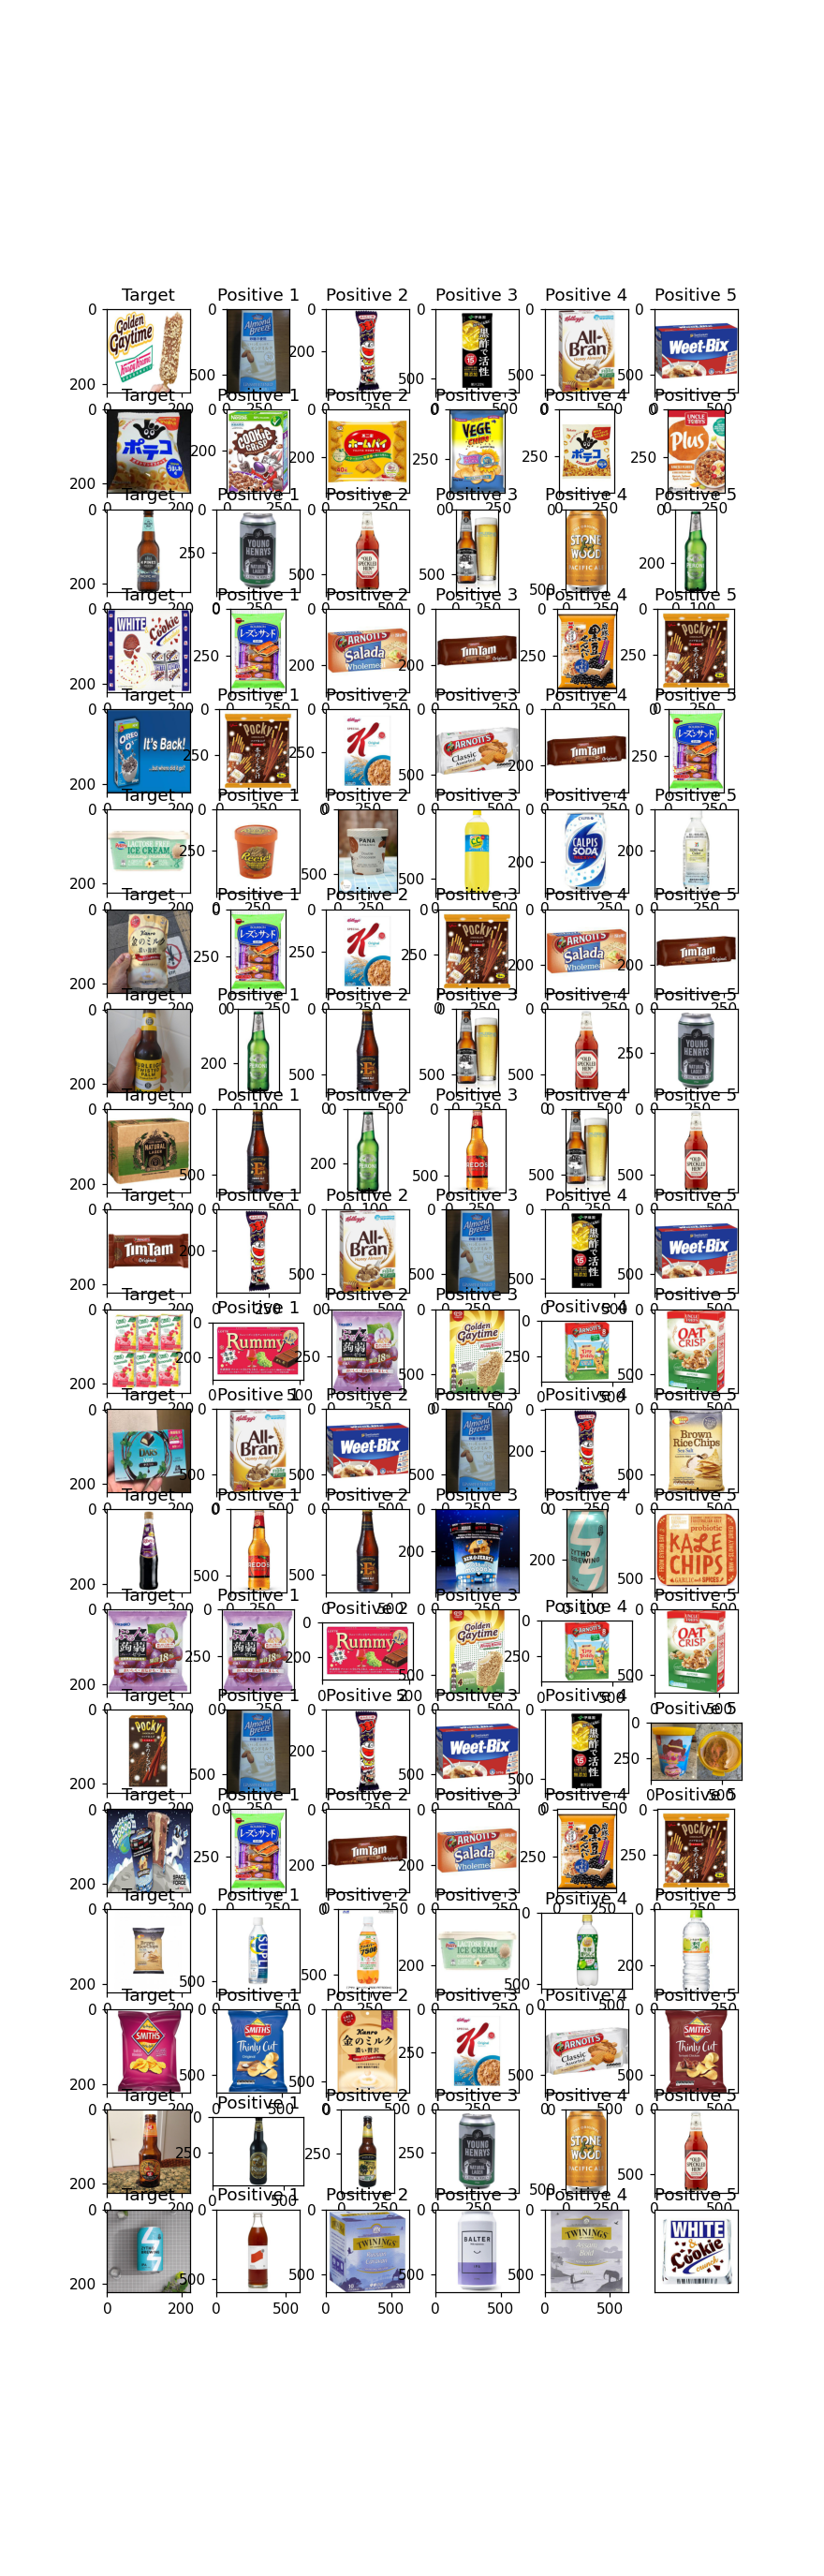

(89, 5)


In [29]:
k = 5
#_row = eu_dist.shape[0]
_row = 20
_col = k + 1

fig4, axs4 = plt.subplots(_row, _col, figsize=(8,25))
#fig4, axs4 = plt.subplots(_row, _col)

_, top_args = get_topK(eu_dist, k = k)

for i in range(_row):
    axs4[i, 0].imshow(target_list[i])
    #axs4[i, 0].set_aspect(10)
    axs4[i, 0].set_title('Target')
    
    for j in range(k):
        img1_file = rep_emb_list[np.squeeze(top_args[i, j])]
        img1 = tf.keras.preprocessing.image.load_img(img1_file)
        img1 = tf.keras.preprocessing.image.img_to_array(img1)
        img1 /= 255.
        axs4[i, j + 1].imshow(img1)
        #axs4[i, j + 1].set_aspect(10)
        axs4[i, j + 1].set_title('Positive {}'.format(j + 1))

plt.xticks([])
plt.yticks([])
plt.show()

## Discussion

I thought the plot looked quite well. However, the score (top-K ranking) is not as good as I expected.

In Triplet loss, 7 to 8 out of 10 achieved Top-5. Compared to that, this model marked only 25/89.
